In [1]:
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree


In [4]:
#Load in meta train and test sets
meta_train = pd.read_csv("review_meta_train.csv")
meta_test = pd.read_csv("review_meta_test.csv")
text_train = pd.read_csv("review_text_train.csv")
text_test = pd.read_csv("review_text_test.csv")

#Load in vocabulary
vocab = pickle.load(open("train_countvectorizer.pkl", "rb"))
vocab_dict = vocab.vocabulary_

#Load in sparse matrix
sparse_train = scipy.sparse.load_npz("review_text_train_vec.npz")
sparse_test = scipy.sparse.load_npz("review_text_test_vec.npz")

#Load in doc2vec matrices
d2v50_train = pd.read_csv("review_text_train_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
d2v50_test = pd.read_csv("review_text_test_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
d2v100_train = pd.read_csv("review_text_train_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
d2v100_test = pd.read_csv("review_text_test_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
d2v200_train = pd.read_csv("review_text_train_doc2vec200.csv", index_col = False, delimiter = ',', header=None)
d2v200_test = pd.read_csv("review_text_test_doc2vec200.csv", index_col = False, delimiter = ',', header=None)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
#train, review and rating
text_train['rating'] = meta_train['rating']
text_train.groupby('rating').count()

,review
rating,
1,2336
3,6444
5,19288


In [6]:
#Remove reviewer_id column
del meta_train['reviewer_id']
del meta_train['review_id']
del meta_train['date']
del meta_train['business_id']
meta_y_train = meta_train['rating']
meta_train = meta_train.iloc[:, :-1]

In [9]:
###### Trial models for a very naive learner #########
models = [GaussianNB(), MultinomialNB(), DecisionTreeClassifier(max_depth=None, criterion ='entropy'), 
          LogisticRegression()]
for model in models:
    cv_output = cross_val_score(model, meta_train, meta_y_train, cv=5)
    acc, std = np.mean(cv_output), np.std(cv_output)
    print("Model:", model, "Accuracy: ", acc, "SD:", std)

Model: GaussianNB(priors=None, var_smoothing=1e-09) Accuracy:  0.6744696040663813 SD: 0.0050597395086387316
Model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) Accuracy:  0.688684588661169 SD: 0.0006276181106617068
Model: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') Accuracy:  0.6857985457093168 SD: 0.0016991770393398125


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.


Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) Accuracy:  0.6916059014085338 SD: 0.0014767214480818046


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [10]:

#Have a brief view of what the top features are

vectoriser = CountVectorizer()
x2 = SelectKBest(chi2,k=100)

vectoriser.fit(text_train['review'])

X_train = x2.fit_transform(sparse_train,meta_y_train)
X_test = x2.transform(sparse_test)

print(X_train.shape, X_test.shape)
vals = []
top_words = []
for feat_num in x2.get_support(indices=True):
    print(vectoriser.get_feature_names()[feat_num]) 
    top_words.append(feat_num)

(28068, 100) (7018, 100)
15
20
amateurish
aronoff
arun
attable
auuuggghhhhh
avola
award
background
benz
bernardine
biopic
bla
burlesque
cakey
caliente
channel
cured
cureiux
dears
deh
dfh
dhal
dinners
dinnertime
disconcerted
doorguy
drivel
falael
farrow
fidel
fiends
fnke
gnome
grandchild
grow
gushy
homogenized
honshimeji
injects
jordans
lakeside
lavay
leons
limited
lnea
longnot
magnitude
magnolia
mashed
maxisapig
mileniumn
mmmmh
neelam
oc
occasion
ontario
onus
oricchete
outcome
overpowers
pausing
pebbles
permitted
plums
preceded
ranchero
reconfiguration
repast
replicate
romans
romantic
rube
scooping
seed
seedy
sod
spritz
suuuupppper
takaki
tchotchke
tentacles
thyme
tiki
tostado
tyson
unappetizing
undisciplined
vineyards
ving
vino
violate
visceral
vocal
vouray
voy
vulgarities
wimpiest
windmill


In [165]:
values = sparse_train.tocsr()[:,40254].toarray()

In [166]:
counts = {}
for value in np.concatenate(values, axis=0):
    if value != 0:
        if value in counts.keys():
            counts[value] += 1
        else:
            counts[value] = 1

Text(0, 0.5, 'Number of Reviews')

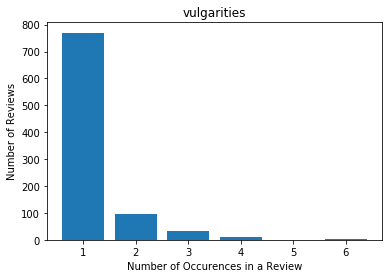

In [167]:
plt.bar(counts.keys(),counts.values())
plt.title(vectoriser.get_feature_names()[40254])
plt.xlabel('Number of Occurences in a Review')
plt.ylabel('Number of Reviews')

Custom CV method that extracts feature per fold

In [11]:
#Function that performs k-fold cross validation by taking in a sparse matrix X, then splitting it into k folds
#before computing the best k features on the training set and fitting it for the test set
def k_fold_cross_val(model, X, y, folds, k, method):
    
    kf = KFold(n_splits=folds,  random_state=None) 
    acc = []
    train_acc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        #vectoriser = CountVectorizer()
        #vectoriser.fit(X_train)
        
        method_residual = SelectKBest(method,k)
        method_residual.fit(X_train, y_train)
        
        X_train2 = method_residual.transform(X_train)
        X_test2 = method_residual.transform(X_test)
        
        model.fit(X_train2.todense(), y_train)
        acc.append(model.score(X_test2.todense(), y_test))
        train_acc.append(model.score(X_train2.todense(), y_train))
        
    return(np.mean(acc), np.mean(train_acc))


In [169]:
#CV for gaussian NB
k_fold_cross_val(GaussianNB(), sparse_train, meta_y_train, 5, 55, chi2)

(0.7433378707414355, 0.7464193860837081)

In [117]:
#Find optimal features
train_acc_gnb = []
val_acc_gnb = []
for index in range(1,150):
    val, train = k_fold_cross_val(GaussianNB(), sparse_train, meta_y_train, 5, index, chi2)
    train_acc_gnb.append(train)
    val_acc_gnb.append(val)
    print(index, train, val)

1 0.6933251969532922 0.693422782916979
2 0.6888271330027811 0.6888271165003172
3 0.6876959603916324 0.6862620623874891
4 0.6859413634430168 0.6836610847470924
5 0.6846141648418618 0.6822361964321336
6 0.6902878968352072 0.689041026509088
7 0.6911073118595493 0.6912854282303454
8 0.705581016847983 0.7058928802297532
9 0.7099276204497709 0.7087430884497545
10 0.7129560348887753 0.711272530033751
11 0.7121722078004964 0.7107025835934457
12 0.7140248538405751 0.713552779119621
13 0.7137932724409856 0.7127689670989359
14 0.7128847713538178 0.7117713720077399
15 0.7116734681718573 0.7103461346125662
16 0.7111034531083287 0.7096691284438111
17 0.7150670228950918 0.7130181469032364
18 0.7164921174752541 0.7138376666564481
19 0.7166435016644137 0.7155478994859699
20 0.7193601220234875 0.7174005253086011
21 0.7206338550243605 0.7178635833871075
22 0.7202686778503417 0.7178992276505042
23 0.7236444183756605 0.7213195409836357
24 0.7236088125896994 0.720606738225572
25 0.7241698987377286 0.7221389

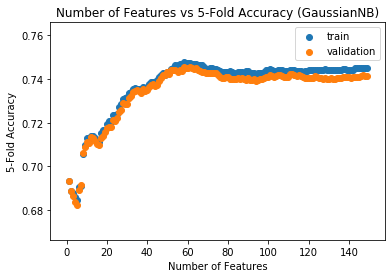

In [122]:
plt.scatter(range(1,150), train_acc_gnb, label = "train")
plt.scatter(range(1,150), val_acc_gnb, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (GaussianNB)')
plt.xlabel('Number of Features')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [95]:
#MNB model
k_fold_cross_val(MultinomialNB(), sparse_train, meta_y_train, 5, 200, chi2)

(0.811956574929021, 0.814290287769506)

In [121]:
#Find optimal features
train_acc_mnb = []
val_acc_mnb = []
for index in range(1,500):
    val, train = k_fold_cross_val(MultinomialNB(), sparse_train, meta_y_train, 5, index, chi2)
    train_acc_mnb.append(train)
    val_acc_mnb.append(val)
    print(index, train, val)

1 0.6871882525777187 0.6871881848914148
2 0.6881323892006771 0.6880076221347574
3 0.692051505998845 0.6923539437273808
4 0.6965940891809053 0.6962728134234163
5 0.7029891502173413 0.7022586822755029
6 0.7044320899352419 0.7037193798735961
7 0.7069705548285689 0.7068902024036903
8 0.71276896954742 0.7127331260812363
9 0.7142118862587858 0.7138020668214424
10 0.7162248354869136 0.7153696972097258
11 0.7174272878962602 0.7160109956459543
12 0.7191730416088851 0.7185762845945634
13 0.71944025537095 0.7189325114334877
14 0.7198054424615785 0.719110605812211
15 0.7230743406391575 0.7222456380999095
16 0.7240095824597543 0.7226375409367954
17 0.7351076056291993 0.7347510432896913
18 0.7368889897209776 0.7356061692248217
19 0.7379132684180153 0.736959991154942
20 0.7418768600213203 0.7410573170037417
21 0.743693886392184 0.7411998242412852
22 0.7459473483153871 0.7446202835534157
23 0.7512024772008711 0.7487885869302717
24 0.7520219378416185 0.7499998254598925
25 0.7530372947631155 0.751175768

201 0.8146643791824417 0.8122416020979341
202 0.8147712635766073 0.8122059895691024
203 0.8149048716476329 0.8120990948603903
204 0.815118639245971 0.8122415830571951
205 0.81559070121082 0.8128473006991568
206 0.8154392785452144 0.8128116818234122
207 0.8154927199489682 0.8130254585470101
208 0.8156263216733637 0.8132036100479503
209 0.8157955470336177 0.8132749049216565
210 0.8159380610136081 0.8133461617138849
211 0.815804456512562 0.8132036481294282
212 0.8160271327965155 0.8134174058122872
213 0.8161607380908903 0.8135955573132273
214 0.8163210734087555 0.8138093086491732
215 0.8164368621252281 0.8137736707326895
216 0.8167218904818732 0.8134886435637764
217 0.8167931456868786 0.8130967724614553
218 0.8170603546889709 0.8131680292536837
219 0.8170069128885524 0.8132392860459119
220 0.816891124568744 0.8133461363262329
221 0.8170069140785456 0.8133817996303685
222 0.8172474041637503 0.8135599384374826
223 0.8172117757679189 0.8134886943390803
224 0.8172384966681282 0.81377368977342

398 0.8267600073517778 0.8198663200490539
399 0.8267867278553227 0.8197594507279942
400 0.8267867278553227 0.8197594570749069
401 0.8268579834569925 0.8196525814069343
402 0.8268847011838865 0.8196525750600212
403 0.8268045396732522 0.8197238191584235
404 0.8268134467722099 0.8195457057389612
405 0.8268846999938934 0.8196169625311895
406 0.8270806561709666 0.8197237874238585
407 0.8271340987647138 0.8195812738394018
408 0.826929232712032 0.8195100297409997
409 0.8270093973959817 0.8196525179378042
410 0.8270806518076581 0.8199731576355489
411 0.8270717443120359 0.8199375324128914
412 0.8272320661433117 0.8196524925501523
413 0.8271608097483132 0.8197237493423805
414 0.8272766028280942 0.8198306377041794
415 0.8270895521633215 0.8197950061346088
416 0.8270895501799995 0.8201156204447015
417 0.8271251785758308 0.8201868772369298
418 0.8270093902560223 0.8202225088065005
419 0.8271519018560264 0.8205787737269029
420 0.8271697180372641 0.8204362855300984
421 0.8273834892055818 0.8209706575

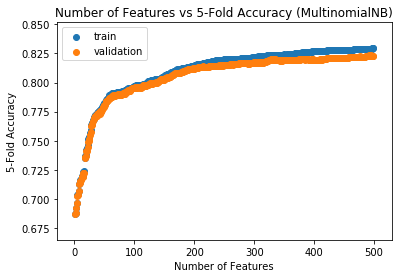

In [124]:
plt.scatter(range(1,500),train_acc_mnb, label = "train")
plt.scatter(range(1,500),val_acc_mnb, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (MultinomialNB)')
plt.xlabel('Number of Features')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [151]:
#Find optimal alpha for MNB
train_acc_mnb_alpha = []
val_acc_mnb_alpha = []
for index in range(1,500):
    val, train = k_fold_cross_val(MultinomialNB(alpha = index), sparse_train, meta_y_train, 5, 300, chi2)
    train_acc_mnb_alpha.append(train)
    val_acc_mnb_alpha.append(val)
    print(index, train, val)

1 0.8218255935284363 0.8172297235329127
2 0.8219235692369864 0.8173366372823635
3 0.8217543319768005 0.8170159848907927
4 0.8217187059609555 0.8172297425736517
5 0.8218434033630437 0.8172653487555703
6 0.8217810516870167 0.8172297362267387
7 0.8217276090932695 0.8173366563231026
8 0.8215049363792953 0.817087235336108
9 0.8216919822840956 0.817087248029934
10 0.8217810552569962 0.8174435066034235
11 0.8217988694549121 0.8175503886183095
12 0.8217899603726322 0.8179423168428475
13 0.8218879352878534 0.8178710663975322
14 0.8217721469680452 0.8178710663975322
15 0.8218968435768044 0.8178354538687005
16 0.8220126322932773 0.8179423358835864
17 0.822012631103284 0.8180492178984723
18 0.8219413774849362 0.8181560999133582
19 0.8218344962640858 0.8181204619968746
20 0.8218345002307299 0.8180136053696406
21 0.821914662534693 0.8178354729094395
22 0.8218968491301059 0.8177285908945537
23 0.8217454340011237 0.8174435954602053
24 0.8217454351911169 0.817586102697749
25 0.8217543411000816 0.817799

200 0.7800965738965833 0.7768633822534345
201 0.7797492045738499 0.7766852497932335
202 0.7795176255542466 0.7764002099304943
203 0.7792058850240092 0.7759726882178637
204 0.7789921182189999 0.7757945557576623
205 0.7786625603175314 0.775438278143434
206 0.778484420321696 0.7751888635033526
207 0.7781726778081366 0.7750107564308032
208 0.7778965617070865 0.774440721133716
209 0.7776649799108325 0.7743338454657431
210 0.7773532385872663 0.7737637847810039
211 0.7770949374774607 0.7735856459738896
212 0.7769078931593183 0.7732649999292319
213 0.7766852180653578 0.7729087223150035
214 0.7764447315501325 0.7730156106768025
215 0.7762131509438719 0.7727662087305469
216 0.7760350137246872 0.7725167940904655
217 0.775856872935523 0.7721249039474054
218 0.7755807568344729 0.7716973505002098
219 0.7751265019275808 0.7712698224406661
220 0.7746811557063039 0.7710204141474974
221 0.7744495754967077 0.7707353869785845
222 0.7742981575910746 0.7705572418245572
223 0.7740131343910667 0.7703434714478

397 0.731126202207965 0.7283025669899212
398 0.7308946219983687 0.728124421835894
399 0.7306541350864789 0.7279106578061222
400 0.7304047406789669 0.727732518999008
401 0.730226602269789 0.727732518999008
402 0.7299950224568571 0.7275187549692361
403 0.7298257895599797 0.727447504523921
404 0.7297278126614362 0.7271981025776655
405 0.7295407679466293 0.7270199764643772
406 0.7294338843457924 0.7269487323659749
407 0.7292913731424528 0.7267705999057738
408 0.7291577690380712 0.7265924610986596
409 0.7289707263065862 0.726449960208029
410 0.7288549379867779 0.7260936889407135
411 0.7286767983876068 0.725951175356257
412 0.7285342875809316 0.7258086554248875
413 0.7283383341805093 0.7256305102708602
414 0.7281780095725828 0.7254879903394906
415 0.7280265924602787 0.7254879966864036
416 0.727848453257772 0.7252029885582295
417 0.7276881274598523 0.725060481320686
418 0.7275010811583879 0.7248823361666588
419 0.7273674782439993 0.7248110793744306
420 0.7271893398348214 0.724454795413289
421

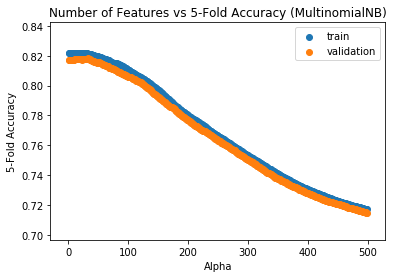

In [153]:
plt.scatter(range(1,500),train_acc_mnb_alpha, label = "train")
plt.scatter(range(1,500),val_acc_mnb_alpha, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (MultinomialNB)')
plt.xlabel('Alpha')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [158]:
train_acc_mnb_alpha2 = []
val_acc_mnb_alpha2 = []
for index in np.arange(0.5,50,0.5):
    val, train = k_fold_cross_val(MultinomialNB(alpha = index), sparse_train, meta_y_train, 5, 300, chi2)
    train_acc_mnb_alpha2.append(train)
    val_acc_mnb_alpha2.append(val)
    print(index, train, val)

0.5 0.821727616629893 0.8170515656850595
1.0 0.8218255935284363 0.8172297235329127
1.5 0.8219859197230205 0.8171228669056786
2.0 0.8219235692369864 0.8173366372823635
2.5 0.8217810536703386 0.8170516291541894
3.0 0.8217543319768005 0.8170159848907927
3.5 0.8217365169855562 0.8170516164603635
4.0 0.8217187059609555 0.8172297425736517
4.5 0.821727610679927 0.8170872162953691
5.0 0.8218434033630437 0.8172653487555703
5.5 0.8217721453813877 0.8174078559931139
6.0 0.8217810516870167 0.8172297362267387
6.5 0.8217276094899336 0.8171941236979071
7.0 0.8217276090932695 0.8173366563231026
7.5 0.8215138446682463 0.8170159975846187
8.0 0.8215049363792953 0.817087235336108
8.5 0.8215316572795046 0.8173366309354506
9.0 0.8216919822840956 0.817087248029934
9.5 0.8216830775651239 0.8172653804901351
10.0 0.8217810552569962 0.8174435066034235
10.5 0.8218255899584566 0.8174435129503366
11.0 0.8217988694549121 0.8175503886183095
11.5 0.8217899627526185 0.8180135736350757
12.0 0.8217899603726322 0.81794231

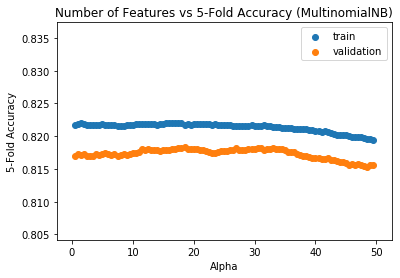

In [160]:
plt.scatter(np.arange(0.5,50,0.5),train_acc_mnb_alpha2, label = "train")
plt.scatter(np.arange(0.5,50,0.5),val_acc_mnb_alpha2, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (MultinomialNB)')
plt.xlabel('Alpha')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [150]:
k_fold_cross_val(MultinomialNB(alpha = 0.001), sparse_train, meta_y_train, 5, 300, chi2)

(0.8170159468093148, 0.8218077793305205)

In [109]:
#Optimal DT
k_fold_cross_val(DecisionTreeClassifier(criterion="entropy"), sparse_train, meta_y_train, 5 , 8, chi2)

(0.7156546291749439, 0.7334687018009377)

In [104]:
train_acc_dt = []
val_acc_dt = []
for index in range(1,40):
    val, train = k_fold_cross_val(DecisionTreeClassifier(criterion="entropy"), sparse_train, meta_y_train, 5, index, chi2)
    train_acc_dt.append(train)
    val_acc_dt.append(val)
    print(index, train, val)

1 0.6946344821904331 0.6945629931432394
2 0.6971729328038418 0.696878943614723
3 0.7009405444302101 0.6983040985000277
4 0.704797279405857 0.7001210546716105
5 0.7092240084218198 0.7000855246526477
6 0.713543889536741 0.7007624038831428
7 0.7181131483992698 0.7043608052480846
8 0.7334687018009377 0.7156902670914274
9 0.7371472801208446 0.7168304709707749
10 0.7437384397368711 0.7166165736558302
11 0.7502404883002151 0.7175073882827482
12 0.756671297921794 0.7198944749551129
13 0.763431664254848 0.7183268572606558
14 0.7708333298129368 0.7146573260417458
15 0.7768722778534117 0.7141229667426202
16 0.7829111882107693 0.7135882647101927
17 0.7900634466680856 0.7187543281979826
18 0.7956213649551015 0.717614359154416
19 0.8022480950539579 0.7188614704363013
20 0.8093736683108604 0.7184694216204164
21 0.8165526206952072 0.7169016833346122
22 0.8220036645046672 0.7161891725345464
23 0.8282919891027565 0.7190749171204234
24 0.8314985050611501 0.7195736638907173
25 0.8393188300534444 0.7186831

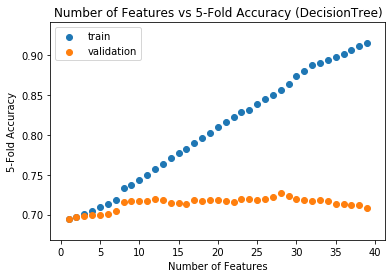

In [107]:
plt.scatter(range(1,40), train_acc_dt, label = "train")
plt.scatter(range(1,40), val_acc_dt, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (DecisionTree)')
plt.xlabel('Number of Features')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [111]:
#CV for DT

def cv_dt(model, X, y, folds, k):
    
    kf = KFold(n_splits=folds,  random_state=None) 
    acc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        #vectoriser = CountVectorizer()
        #vectoriser.fit(X_train)
        
        method_residual = SelectKBest(chi2,k)
        method_residual.fit(X_train, y_train)
        
        X_train2 = method_residual.transform(X_train)
        X_test2 = method_residual.transform(X_test)
        
        clf = model.fit(X_train2.todense(), y_train)
        acc.append(model.score(X_test2.todense(), y_test))
        
        feature_names = []
        for feat_num in method_residual.get_support(indices=True):
            feature_names.append(vectoriser.get_feature_names()[feat_num])
            
        dot_data = tree.export_graphviz(clf, out_file="mytree.dot", 
                                feature_names=feature_names,  
                                class_names=["1","3","5"])
    return(np.mean(acc))
        
        

In [173]:
import pydotplus
from IPython.display import Image
import graphviz
from sklearn.tree import export_graphviz
cv_dt(tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 3), sparse_train, meta_y_train, 5, 8)


0.7099542063880283

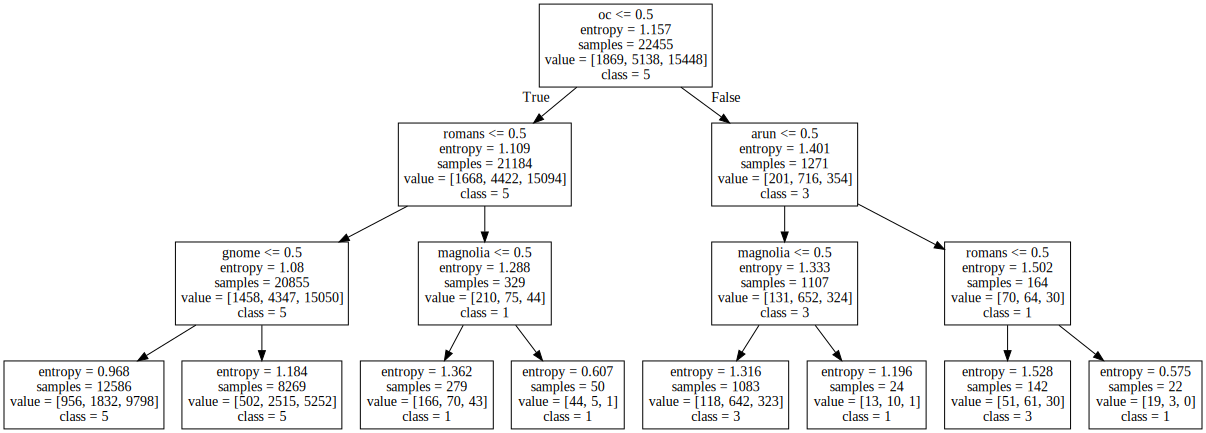

In [116]:
#View a tree
# Convert a .dot file to .png
from graphviz import render
render('dot', 'png', 'mytree.dot')

# To render an existing file in a notebook
from graphviz import Source
Source.from_file("mytree.dot")
    

In [130]:
#Find optimal C value for logistic regression
C_param_range = [0.001,0.01,0.1,1,10,50,100]
train_acc = []
val_acc = []
for val in C_param_range:
    val, train = k_fold_cross_val(LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial", 
                                                     C = val), sparse_train, meta_y_train, 5 , 200, chi2)
    train_acc.append(train)
    val_acc.append(val)

In [147]:
val, train = k_fold_cross_val(LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial", C = 10), 
                              sparse_train, meta_y_train, 5 , 125, chi2)

In [148]:
print(train, val)

0.8148603567793922 0.80885723133311


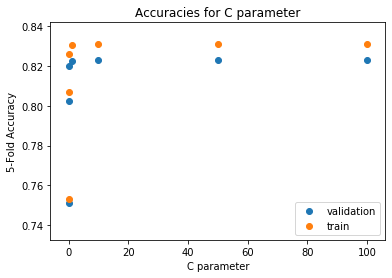

In [131]:
plt.scatter(C_param_range, val_acc, label = "validation")
plt.scatter(C_param_range, train_acc, label = "train")
plt.xlabel("C parameter")
plt.ylabel("5-Fold Accuracy")
plt.title("Accuracies for C parameter")
plt.legend()

In [144]:
#Find optimal features
train_acc_logr = []
val_acc_logr = []
for index in range(5,300):
    val, train = k_fold_cross_val(LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial", C = 10), 
                                  sparse_train, meta_y_train, 5 , index, chi2)
    train_acc_logr.append(train)
    val_acc_logr.append(val)
    print(index, train, val)
    
    

5 0.7030069687785654 0.7024725161213177
6 0.7048150983637455 0.7041826220125795
7 0.7072912183243399 0.707210975386608
8 0.7188345984250005 0.7185048183542062
9 0.7210880512249224 0.7204644467830703
10 0.7236888892141538 0.7226020680400498
11 0.7250605570671445 0.7240272165784414
12 0.7279286000918239 0.7274475299115729
13 0.7288549225168666 0.7281600216708999
14 0.7296565384165399 0.7281601676498987
15 0.7313310611206875 0.7302620875212645
16 0.7323019162638689 0.7304045693711562
17 0.7363813108635647 0.7350361656622995
18 0.7384298920575035 0.7365325075237894
19 0.7397302793189677 0.7382070453146105
20 0.7437740308462495 0.7414847879410684
21 0.7456801468499185 0.742019172627846
22 0.747470444387285 0.743800782840943
23 0.7509530863633386 0.748360931932468
24 0.7520931902699732 0.7500709680076869
25 0.753295598649572 0.7519594348480177
26 0.7577490767289158 0.7549521693463015
27 0.7598956419613572 0.7570185782394437
28 0.7638770489525709 0.7611870910644287
29 0.7657296696061284 0.762

204 0.8313560148810233 0.8233932869082036
205 0.8319438627856941 0.8236070826725402
206 0.831979488404875 0.8235001816169154
207 0.8322110717877864 0.823642682507546
208 0.8324337520383839 0.823642676160633
209 0.8326475144800849 0.8233932615205516
210 0.8328256536825915 0.823535781451921
211 0.8327633055765441 0.8235714066745787
212 0.8329681652825955 0.8237495327878669
213 0.8330127003807204 0.8235001562292634
214 0.8332086577477869 0.8236783077302036
215 0.8332977287373655 0.8235714637967957
216 0.8334669632209005 0.8234645627411709
217 0.8338677791040252 0.8237496026039098
218 0.8340548210421813 0.8236427142421109
219 0.8339657532259178 0.8236070826725402
220 0.8342240559223809 0.8237139773812523
221 0.8344378219340614 0.823357687073198
222 0.8346159615332324 0.8230726916388498
223 0.834811916123648 0.8229301970951323
224 0.8348653539574225 0.8233220872381922
225 0.8350969333736901 0.8234289311716001
226 0.8354621228443051 0.8232863921994916
227 0.8355868234197084 0.823713939299774

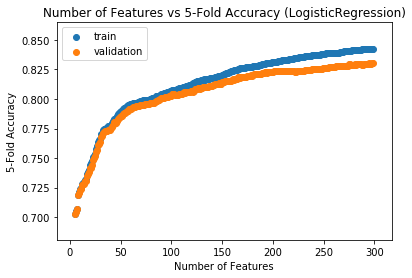

In [146]:
plt.scatter(range(5,300),train_acc_logr, label = "train")
plt.scatter(range(5,300),val_acc_logr, label = "validation")
plt.title('Number of Features vs 5-Fold Accuracy (LogisticRegression)')
plt.xlabel('Number of Features')
plt.ylabel('5-Fold Accuracy')
plt.legend()

In [163]:
#Selecting best features with mutual information
mi = SelectKBest(mutual_info_classif,k=100)

X_trainmi = mi.fit_transform(sparse_train,meta_y_train)
X_testmi = mi.transform(sparse_test)

print(X_trainmi.shape, X_testmi.shape)
for feat_num in mi.get_support(indices=True):
    print(vectoriser.get_feature_names()[feat_num])
    
    
    

(28068, 100) (7018, 100)
15
20
amateurish
aronoff
arun
attable
auuuggghhhhh
avola
award
background
benz
bernardine
biopic
bla
burlesque
cakey
caliente
channel
cheong
cured
cureiux
dears
deh
dfh
dhal
dinners
dinnertime
disconcerted
doorguy
drivel
everyday
falael
farrow
fcking
fidel
fiends
fnke
gnome
gongbao
grandchild
grow
henry
homogenized
honshimeji
impromptu
injects
jordans
lavay
leons
limited
lnea
longnot
magnolia
mashed
maxisapig
mileniumn
mmmmh
neelam
oc
occasion
ontario
onus
oricchete
outcome
overpowers
pausing
pebbles
pecking
plums
preceded
ranchero
replicate
romans
rube
scooping
seed
seedy
sod
spritz
suuuupppper
takaki
talcott
tchotchke
tentacles
thyme
tiki
tyson
unappetizing
vineyards
ving
vino
violate
vocal
vouray
voy
vulgarities
whoop
wimpiest
windmill
wineries


In [179]:
#Predictions
x2 = SelectKBest(chi2, 125)
x2.fit(sparse_train,meta_y_train)
X_train_x2 = x2.transform(sparse_train)
X_predict_x2 = x2.transform(sparse_test)

models = []
#Choose model to predict
model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial", C = 10)
model.fit(X_train_x2.todense(), meta_y_train)
predicted = model.predict(X_predict_x2.todense())
data = {'Instance_id':[],
        'rating':[]}
predictions = pd.DataFrame(data, columns = ['Instance_id', 'rating'])
predictions['rating'] = predicted
predictions["Instance_id"] = predictions.index + 1


In [180]:
predictions.to_csv('1125895.csv', index=False)

In [12]:
################### All models used ###################
print("Logistic Regression:", k_fold_cross_val(LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial", C = 10), 
                              sparse_train, meta_y_train, 5 , 125, chi2)[0])
print("Decision Tree:", k_fold_cross_val(DecisionTreeClassifier(criterion="entropy"), sparse_train, meta_y_train, 
                                         5 , 8, chi2)[0])
print("MultinomialNB:", k_fold_cross_val(MultinomialNB(alpha = 1), sparse_train, meta_y_train, 5, 300, chi2)[0])
print("GaussianNB:", k_fold_cross_val(GaussianNB(), sparse_train, meta_y_train, 5, 55, chi2)[0])


Logistic Regression: 0.80885723133311
Decision Tree: 0.7158683932047157
MultinomialNB: 0.8172297235329127
GaussianNB: 0.7433378707414355
